# Assignment 1: Convolutional Neural Networks (CNNs)


## Import Packages


In [1]:
# Import torch packages
import torch
import torchvision as torchv

# Packages that are nice to have
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
torch.cuda.is_available()

True

## Get the Dataset


In [3]:
train_dataset = torchv.datasets.CIFAR10(
    root='./dataset/train',
    train=True,
    download=True,
    transform=torchv.transforms.ToTensor()
)
test_dataset = torchv.datasets.CIFAR10(
    root='./dataset/test',
    train=False,
    download=True,
    transform=torchv.transforms.ToTensor()
)

100%|██████████| 170M/170M [00:01<00:00, 102MB/s]  
100%|██████████| 170M/170M [00:01<00:00, 87.1MB/s] 


### What does the data look like?


In [4]:
print(train_dataset[0])
print(type(train_dataset[0]))

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0

A single sample of the data is a tuple of length 2. This will be the input into our convolutional neural network!


In [5]:
# First element of tuple. This is an image!
print(train_dataset[0][0].shape)
print(type(train_dataset[0][0]))

torch.Size([3, 32, 32])
<class 'torch.Tensor'>


You may not be familiar with what a "tensor" is as of now. Just think of it as a datatype similar to an array!


Now we can look at a single sample of the second element. This will be our label (or "target" in PyTorch) to compare the output of our network to in order to determine the loss or error of our network so we can tell the network how to improve the network.

Keep in mind this is can also be called the ground-truth of the input sample.


In [6]:
# Second element is just a single integer!
print(train_dataset[0][1])
print(type(train_dataset[0][1]))

6
<class 'int'>


### What are these two elements of the single sample?


- The first element is an image of shape 1x28x28 (NumberOfChanngels \* Width \* Height) representing a single handwritten digit (i.e. a number between 0 and 9).
- The second element is a single digit integer representing the handwritten digit's perceived value contained within the image.


In the first element of the tuple, we see that the shape of the image is 1x28x28. Why do we have the single 1 in the front? This is the number of color channels the image has in it. In this case, we only have one color channel conveying that this image is simply a gray scale image!


**_Q1: How many color channels does a traditional colored image have?_**


Keep in mind that this is only ONE sample of the dataset!


In [7]:
print(f'There are {len(train_dataset)} samples in the training dataset!')
print(f'There are {len(test_dataset)} samples in the test dataset!')
print(
    f'Thus we have {len(train_dataset) + len(test_dataset)} ' +
    'samples in total!\n' +
    f'That is, we have a total of {len(train_dataset) + len(test_dataset)} ' +
    'tuples containing a single grayscale image and a single digit integer!'
)

There are 50000 samples in the training dataset!
There are 10000 samples in the test dataset!
Thus we have 60000 samples in total!
That is, we have a total of 60000 tuples containing a single grayscale image and a single digit integer!


### Combine and Split the Data


We currently have two separate parts of the dataset: the training data and the testing data. For this example we will combine these two into one large dataset of 70,000 samples and then split the dataset into three new datasets: train, validation, and testing.


In [8]:
# Get the data into numpy arrays
# (convert data to numpy format to manipulate later)
train_images = train_dataset.data
train_labels = np.array(train_dataset.targets)
test_images = test_dataset.data
test_labels = np.array(test_dataset.targets)
print(
    f'Train Images: {train_images.shape}\n' +
    f'Train Labels: {train_labels.shape}\n' +
    f'Test Images: {test_images.shape}\n' +
    f'Test Labels: {test_labels.shape}\n'
)

Train Images: (50000, 32, 32, 3)
Train Labels: (50000,)
Test Images: (10000, 32, 32, 3)
Test Labels: (10000,)



In [9]:
# Combine the train and test dataset into one big dataset
all_images = np.concatenate((train_images, test_images))
all_labels = np.concatenate((train_labels, test_labels))
print(
    f'All Images: {all_images.shape}\n' +
    f'All Labels: {all_labels.shape}\n'
)

All Images: (60000, 32, 32, 3)
All Labels: (60000,)



Notice! That the color channel dimension of 1 was removed! This is fine for now. We will add it back later!


So now that we have one large dataset, we split the data into the proportions we wish to use for our three separate datasets for training, validation, and testing.


In [10]:
# Split the large numpy array into smaller train, validation, and test splits
choices = np.arange(len(all_labels))
# Specify the percentages of samples each set should contain
# NOTE: The last percentage is not important here since we will just
#       use the remaining images after we take out the training and validation
#       sets.
train_perc, val_perc, test_perc = (0.7, 0.2, 0.1)
# Get the number of total samples
num_samples = len(all_labels)
# Calculate the number train samples we want
num_train = int(np.floor(num_samples * train_perc))
# Calculate the number of validation samples we want
num_val = int(np.floor(num_samples * val_perc))
# Calculate the number of test samples we want
num_test = num_samples - num_train - num_val
# Show the number of samples in each
num_train, num_val, num_test

(42000, 12000, 6000)

In [11]:
# Randomly select indices throughout the whole dataset
train_idx = np.random.choice(choices, num_train, replace=False)
# Get the set difference between the whole dataset and the chosen training
# indices
choices = np.setdiff1d(choices, train_idx)
# Now get randomly choose the validation indices
val_idx = np.random.choice(choices, num_val, replace=False)
# Similarly, get the set difference but this time the resulting difference
# is, in fact, the test set.
test_idx = np.setdiff1d(choices, val_idx)
# Show index sets
train_idx, val_idx, test_idx

(array([12910, 42451, 51393, ..., 20945, 45026, 51142]),
 array([ 2192, 22192, 14467, ..., 26455, 41799, 18929]),
 array([    3,     4,    39, ..., 59987, 59988, 59990]))

In [12]:
# Ensure disjoint sets i.e. none of the elements overlap between the new
# three datasets of train, validation, and test.
np.intersect1d(np.intersect1d(train_idx, val_idx), test_idx)

array([], dtype=int64)

In [13]:
# Now we actually get all of the images and labels corresponding to their
# sets using the indices we randomly chose
train_images, train_labels = all_images[train_idx], all_labels[train_idx]
val_images, val_labels = all_images[val_idx], all_labels[val_idx]
test_images, test_labels = all_images[test_idx], all_labels[test_idx]

### Helper Functions and Custom Dataset Definition


In [14]:
def transform(image):
    """Perform a transform on an input image. This can include normalization,
    padding, and other transformations/augmentations.

    :param image: The input image.
    :type image: Typically a numpy array.
    :return: A new transformed image.
    :rtype: _type_
    """
    # I used ChatGPT to help me with this part
    x = image.transpose(2, 0, 1)      # (3, 32, 32)
    x = torch.from_numpy(x).float() / 255.0

    return x


def target_transform(label):
    """Perform transformations on the label (i.e. "target").

    :param label: An input integer in this case
    :type label: A number that we should typecast to integer.
    :return: A transformed label.
    :rtype: int
    """
    x = int(label)
    return x


class CIFAR10_Dataset(torch.utils.data.Dataset):
    """Create a custom PyTorch dataset with all of the necessary functions to
    properly work with other PyTorch operations/functions.
    """

    def __init__(
        self, 
        images,
        labels,
        transform=transform,
        target_transform=target_transform
    ):
        """The constructor for the class. Initialize variables.

        :param images: A group of images.
        :param labels: A group of labels.
        :param transform: Transform function to apply to images, 
            defaults to transform
        :type transform: function, optional
        :param target_transform: Transform function to apply to the labels,
            defaults to target_transform
        :type target_transform: function, optional
        """
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """Get the length of the dataset.

        :return: The length of the labels i.e. the number of elements in the
            dataset.
        :rtype: int
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """Get a single element of the dataset via its index and perform the
        necessary transforms upon it.

        :param idx: The index of the element to retrieve.
        :type idx: int
        :return: A tuple grouping the image and the label.
        :rtype: tuple
        """
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [15]:
# Use our custom dataset definition class to wrap our dataset for use with other
# PyTorch tools i.e. the PyTorch dataloader.
train_dataset = CIFAR10_Dataset(
    train_images, train_labels, transform=transform, target_transform=target_transform)
val_dataset = CIFAR10_Dataset(
    val_images, val_labels, transform=transform, target_transform=target_transform)
test_dataset = CIFAR10_Dataset(
    test_images, test_labels, transform=transform, target_transform=target_transform)

## Visualize the Data


Now let's pause and analyze our data.


[6 9 9 ... 5 1 7]


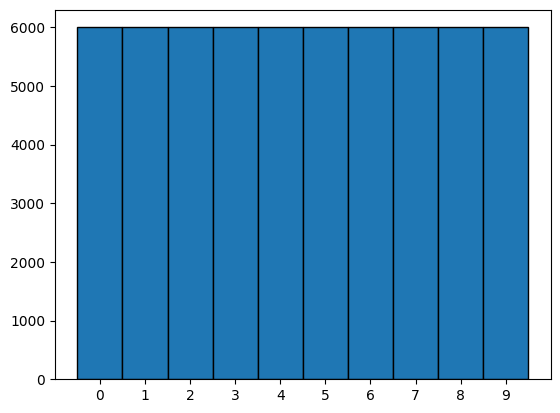

In [16]:
# Histogram showing the frequency of each class in the dataset
print(all_labels)
plt.hist(all_labels, bins=np.arange(11) - 0.5, edgecolor='black')
plt.xticks(range(10))
plt.show()

We can see that we have mixed distribution of frequencies among the 10 classes of handwritten digits with handwritten 1s having the most samples and the 5s having the least samples.


**_Q2: What happens if our distribution is very unbalanced meaning we have widely different quantities of the classes?_**


Now, if we look at the distribution over the train, validation, and test sets, we can see that the distributions are roughly proportional to what we saw previously when the all of the data was contained within a single large dataset.


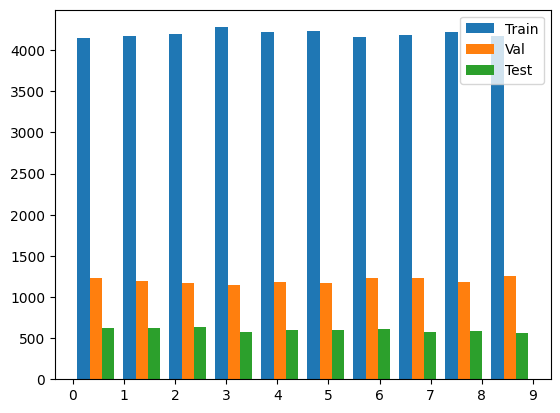

In [17]:
# Frequencies of each class in the 3 separate datasets
labels = np.unique(train_labels)
plt.hist([train_labels, val_labels, test_labels])
plt.xticks(labels)
plt.legend(['Train', 'Val', 'Test'])

Now we can get an idea of what our data actually looks like. Here, we have printed a single sample of each class and displayed their corresponding label above them.


In [18]:
# Displaying one sample of each class
"""
visualization_samples = []
plt.subplot(2, 5, 1)
for i in range(10):
    indices = np.where(train_labels == i)[0]
    rand_idx = indices[np.random.randint(0, len(indices) - 1)]
    plt.subplot(2, 5, i+1)
    plt.imshow(np.squeeze(train_images[rand_idx]))
    plt.yticks([])
    plt.xticks([])
    plt.title(i)
    """

'\nvisualization_samples = []\nplt.subplot(2, 5, 1)\nfor i in range(10):\n    indices = np.where(train_labels == i)[0]\n    rand_idx = indices[np.random.randint(0, len(indices) - 1)]\n    plt.subplot(2, 5, i+1)\n    plt.imshow(np.squeeze(train_images[rand_idx]))\n    plt.yticks([])\n    plt.xticks([])\n    plt.title(i)\n    '

## Create the Dataloaders


In many cases our entire dataset may not fit entirely in memory (i.e. RAM). In our case of MNIST, this typically isn't a problem, but for larger datasets and higher dimensional data (i.e. ImageNet datasets), it is common that we need a way to load our data such that it fits in memory.

We can customize the code in the MNIST_Dataset class to allow use to only read data from the disk (Hard Drive or Solid State Drive) when needed. This can be seen in the PyTorch examples of the Dataset and Dataloader documentation/tutorials: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

In this case, we are not concerned with memory limitations, unless the system you are running this tutorial on is extremely limited in memory. Thus we have the entire dataset loaded into memory and can freely manipulate it.

In many cases, it is much more efficient to use data batching to batch our data when training to speed up training. Instead of inputting a single image, computing the loss, and then backpropogating the error and adjusting the weights, we can perform the forward pass (i.e. input) several images at once and then compute the loss on those samples together and then backpropogate their error.


**_Q3: What do we mean by "train faster" or "more efficiently" here? That is what is faster or more efficient?_**


### Parameters


In [19]:
# In this tutorial, we will use a batch size of 32 whilst training
BATCH_SIZE = 32

In [20]:
# Here we initialize the Dataloaders, set the batch size to load BATCH_SIZE
# samples at a time and also perform a random shuffle of the samples within
# each set of data.
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

## Create the CNN Model


Here we instantiate two CNN models both being based off of Yann LeCun et. al.'s LeNet-5 CNN proposed in their publication "Gradient-Based Learning Applied to Document Recognition" circa 1998.


### Parameters


In [21]:
# We have 10 different classes of data we want to differentiate between
# (i.e. the handwritten single digit number zero thru nine)
NUM_CLASSES = 10

### VGG Model


In [22]:
class VGGModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define the layers
        self.conv1 = torch.nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.conv4 = torch.nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1)) # ChatGPT helped me with this
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(128, 100)
        self.linear2 = torch.nn.Linear(100, 75)
        self.linear3 = torch.nn.Linear(75, 50)
        self.linear4 = torch.nn.Linear(50, 35)
        self.linear5 = torch.nn.Linear(35, out_features=NUM_CLASSES)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.functional.F.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = torch.functional.F.relu(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = torch.functional.F.relu(x)
        x = self.conv4(x)
        x = torch.functional.F.relu(x)
        x = self.maxpool3(x)
        x = self.avgpool(x)

        x = self.flatten(x)
        # print(f"shape of flat vector {x.shape}")

        x = self.linear1(x)
        x = torch.functional.F.relu(x)
        x = self.linear2(x)
        x = torch.functional.F.relu(x)
        x = self.linear3(x)
        x = torch.functional.F.relu(x)
        x = self.linear4(x)
        x = torch.functional.F.relu(x)
        x = self.linear5(x)
        return x

In [23]:
print(test_images[0].shape)

(32, 32, 3)


### Inspect the VGG Model


In [24]:
vgg_model = VGGModel()
summary(vgg_model, (BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VGGModel                                 [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 32, 32]          1,792
├─MaxPool2d: 1-2                         [32, 64, 16, 16]          --
├─Conv2d: 1-3                            [32, 128, 16, 16]         73,856
├─MaxPool2d: 1-4                         [32, 128, 8, 8]           --
├─Conv2d: 1-5                            [32, 128, 8, 8]           147,584
├─Conv2d: 1-6                            [32, 128, 8, 8]           147,584
├─MaxPool2d: 1-7                         [32, 128, 4, 4]           --
├─AdaptiveAvgPool2d: 1-8                 [32, 128, 1, 1]           --
├─Flatten: 1-9                           [32, 128]                 --
├─Linear: 1-10                           [32, 100]                 12,900
├─Linear: 1-11                           [32, 75]                  7,575
├─Linear: 1-12                           [32, 50]            

**_Q4: What are the architectural differences between these two models?_**


## Setup the Loss Functions and Optimizer


### Paremeters


In [25]:
# This is our learning rate for both models
LEARNING_RATE = 0.001

In [26]:
# Setup our loss function
loss = torch.nn.CrossEntropyLoss()

# Setup an optimizer for each of the two models
optim_vgg = torch.optim.Adam(
    vgg_model.parameters(), lr=LEARNING_RATE)
# optim_modern_lenet5 = torch.optim.Adam(
    # modern_lenet5.parameters(), lr=LEARNING_RATE)

## Train the CNN Model


### Parameters


In [27]:
# Define the number of training epochs to loop of the entire dataset
NUM_EPOCHS = 15
# Determine if we should use
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
def compute_accuracy(outputs, labels):
    """Use the outputs from the network and the expected labels to compute the
    accuracy of the network. 

    :param outputs: The output provided by running the model on input.
    :param labels: The ground-truth labels of the dataset.
    :return: The accuracy of the network based on the output of the network.
    :rtype: float
    """
    # Get the class index with the highest activation
    # In this case it corresponds to the digit with the highest likelihood of
    # being the number depicted in the input
    predictions = torch.argmax(outputs, 1)
    # Number of total predictions (i.e. the batch size)
    num_predictions = len(predictions)
    # Count the number of elements in the difference that are NOT zero
    # This indicates a mis-classification by the model
    num_incorrect = torch.count_nonzero(predictions - labels)
    # Compute the accuracy i.e. total - incorrect divided by total
    accuracy = (num_predictions - num_incorrect)/num_predictions
    return accuracy.item()

In [29]:
def train(
    train_dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_function,
    optimizer,
    epoch: int,
    num_epochs: int,
    total_steps: int,
    device: str
) -> tuple:
    """Perform a full iteration over the entire training dataset.

    :param train_dataloader: The dataloader to use to get the data.
    :type train_dataloader: torch.utils.data.DataLoader
    :param model: The model to train.
    :type model: torch.nn.Module
    :param loss_function: The loss function to use to compute the loss.
    :param optimizer: The optimizer to use during training.
    :param epoch: The epoch number.
    :type epoch: int
    :param num_epochs: Total number of epochs.
    :type num_epochs: int
    :param total_steps: Total number of loops due to batching.
    :type total_steps: int
    :param device: The device to train on.
    :type device: str
    :return: A tuple containing average loss and accuracy.
    :rtype: tuple
    """
    running_acc = 0.0
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        # Move the data to the desired training device
        images = images.to(device)
        labels = labels.to(device)

        # Perform the forward pass
        outputs = model(images)

        # Compute the loss
        loss = loss_function(outputs, labels)

        # Compute accuracy metric
        acc = compute_accuracy(outputs, labels)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform the backwards pass (i.e. backpropogate the error)
        loss.backward()

        # Optimize
        optimizer.step()

        # Add the running accuracy and loss
        running_loss += loss.item()
        running_acc += acc

        # Progressively print loss
        if (i+1) % 256 == 0:
            print(
                f'TRAINING --> Epoch: {epoch+1}/{num_epochs}, ' +
                f'Step: {i+1}/{total_steps}, ' +
                f'Loss: {running_loss / (i+1)}, '
                f'Accuracy: {running_acc / (i+1)}'
            )
    # Compute the average loss and accuracy for this epoch
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps

    return running_loss, running_acc

In [30]:
def validation(
    val_dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_function,
    epoch: int,
    num_epochs: int,
    total_steps: int,
    device: str
) -> tuple:
    """Perform inference over the entire validation dataset without training
    the model.

    :param val_dataloader: The validation dataset DataLoader to get data.
    :type val_dataloader: torch.utils.data.DataLoader
    :param model: The model to use to perform inference.
    :type model: torch.nn.Module
    :param loss_function: The loss function to use to compute the loss with.
    :param epoch: The current epoch number.
    :type epoch: int
    :param num_epochs: Total number of epochs.
    :type num_epochs: int
    :param total_steps: Total number of loop iteration due to batching.
    :type total_steps: int
    :param device: The device to perform inference on.
    :type device: str
    :return: The average validation loss and accuracy.
    :rtype: tuple
    """
    running_loss = 0.0
    running_acc = 0.0
    # Now we run over the validation dataset without training
    if val_dataloader:
        # Disable the gradient calculations and updates
        with torch.no_grad():
            for i, (images, labels) in enumerate(val_dataloader):
                # Transfer input data to device
                images = images.to(device)
                labels = labels.to(device)

                # Perform inference
                outputs = model(images)

                # Compute validation loss
                loss = loss_function(outputs, labels)

                # Compute validation accuracy
                acc = compute_accuracy(outputs, labels)

                # Add the running accuracy and loss
                running_loss += loss.item()
                running_acc += acc

                # Progressively print loss
                if (i+1) % 256 == 0:
                    print(
                        f'VALIDATION --> Epoch: {epoch+1}/{num_epochs}, ' +
                        f'Step: {i+1}/{total_steps}, ' +
                        f'Val Loss: {running_loss / (i+1)}, ' +
                        f'Val Acc: {running_acc / (i+1)}'
                    )
    # Compute the average loss and accuracy for this epoch
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps

    return running_loss, running_acc

In [31]:
def save_best_model(
    model: torch.nn.Module,
    model_save_path: Path,
    val_loss: float,
    val_losses: list,
    epoch: int,
    keep_models: bool = False
):
    """Save the model if it is the first epoch. Subsequently, save the model
    only if a lower validation loss is achieved whilst training.

    :param model: The model to save.
    :type model: torch.nn.Module
    :param model_save_path: The location to save the model to.
    :type model_save_path: Path
    :param val_loss: The current epoch's validation loss.
    :type val_loss: float
    :param val_losses: The history of all other validation losses.
    :type val_losses: list
    :param epoch: The current epoch number.
    :type epoch: int
    :param keep_models: Should all models be saved, defaults to False
    :type keep_models: bool, optional
    """
    # Should we keep all models or just one
    if keep_models:
        model_save_path = model_save_path / f'model_{epoch+1}_{val_loss}.pt'
    else:
        model_save_path = model_save_path / f'model_state_dict.pt'
    # Save the first model
    if len(val_losses) == 0:
        torch.save(
            model.state_dict(),
            model_save_path
        )
        print(
            'SAVING --> First epoch: \n' +
            f'Val Loss: {val_loss}\n' +
            f'Saving new model to:\n{model_save_path}'
        )
    elif val_loss < min(val_losses):
        # If our new validation loss is less than the previous best save the
        # model
        print(
            'SAVING --> Found model with better validation loss: \n' +
            f'New Best Val Loss: {val_loss}\n' +
            f'Old Best Val Loss: {min(val_losses)}\n'
            f'Saving new model to:\n{model_save_path}'
        )
        torch.save(
            model.state_dict(),
            model_save_path
        )

In [32]:
def train_model(
    train_dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_function: torch.nn.CrossEntropyLoss,
    optimizer: torch.optim.Adam,
    num_epochs: int,
    device: str,
    model_save_path: Path = Path('./models'),
    val_dataloader: torch.utils.data.DataLoader = None,
) -> tuple:
    """Training loop which iterates over every image in the training dataset,
    performs the forward pass, computes the loss, and then performs the
    backwards pass. This also loops over the validation dataset and computes
    the validation loss and accuracy to determine the best model.

    See: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

    :param train_dataloader: The training dataset DataLoader to get data.
    :type train_dataloader: torch.utils.data.DataLoader
    :param model: The model to train.
    :type model: torch.nn.Module
    :param loss_function: The loss function to use to compute the loss.
    :type loss_function: torch.nn.CrossEntropyLoss
    :param optimizer: The optimizer to use in updating the weights.
    :type optimizer: torch.optim.Adam
    :param num_epochs: Total number of epoch to train for.
    :type num_epochs: int
    :param device: The device to perform training and validation on.
    :type device: str
    :param model_save_path: Save the model to, defaults to Path('./models')
    :type model_save_path: Path, optional
    :param val_dataloader: The validation dataset loader, defaults to None
    :type val_dataloader: torch.utils.data.DataLoader, optional
    :return: A tuple of shape (2, 2) that contains the history of the train
        and validation losses and accuracies.
    :rtype: tuple
    """
    print(f'Models will be saved to: {model_save_path}')
    # Lists for recording stats over epochs
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Create the save path for the model
    if not model_save_path.exists():
        model_save_path.mkdir(exist_ok=True, parents=True)

    # Total number batches in training set
    train_total_steps = len(train_dataloader)
    val_total_steps = len(val_dataloader)

    # Perform training loop
    for epoch in range(num_epochs):
        # Enable model training
        model.train(True)

        # Enter the training function loop
        train_loss, train_acc = train(
            train_dataloader,
            model,
            loss_function,
            optimizer,
            epoch,
            num_epochs,
            train_total_steps,
            device
        )
        print(
            f'TRAINING --> Epoch {epoch+1}/{NUM_EPOCHS} DONE, ' +
            f'Avg Loss: {train_loss}, Avg Accuracy: {train_acc}'
        )

        # Enter the validation loop
        val_loss, val_acc = validation(
            val_dataloader,
            model,
            loss_function,
            epoch,
            num_epochs,
            val_total_steps,
            device
        )
        print(
            f'VALIDATION --> Epoch {epoch+1}/{NUM_EPOCHS} DONE, ' +
            f'Avg Loss: {val_loss}, Avg Accuracy: {val_acc}'
        )

        # Determine if we should save the model
        save_best_model(model, model_save_path, val_loss, val_losses, epoch)

        # Record the stats
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    return (train_losses, train_accs), (val_losses, val_accs)

**_Q5: What is the purpose of the loss function?_**

**_Q6: What is validation doing?_**

**_Q7: Why do we perform validation and not just use the training loss/accuracy?_**


In [33]:
def plot_epoch_metrics(x, y, data_names, title_prefix, yaxis_label):
    """Plot metrics with the number of epochs on the x axis and the metric of
    interest on the y axis. Note that this function differs based on the input.

    :param x: The values to use on the x-axis.
    :type x: list
    :param y: A list of lists containing len(x) data points to plot. The inner
        lists are the different series to plot.
    :type y: list
    :param data_names: Names of the series to use in the legend.
    :type data_names: str
    :param title_prefix: A prefix to add before everything else in the title.
    :type title_prefix: str
    :param yaxis_label: The label for the y axis.
    :type yaxis_label: str
    """
    # Plot multiple series of data
    for i in y:
        plt.plot(x, i)
    # Set the title
    plt.title(title_prefix + ' ' + ' vs. '.join(data_names) + ' ' + yaxis_label)
    # Set the y axis label
    plt.ylabel(yaxis_label)
    # Enable the legend with the appropriate names
    plt.legend(data_names)

In [34]:
# Train the VGG Model
vgg_model.to(DEVICE)
(train_losses, train_accs), (val_losses, val_accs) = train_model(
    train_dataloader,
    vgg_model,
    loss,
    optim_vgg,
    NUM_EPOCHS,
    DEVICE,
    model_save_path=Path('./models/vgg'),
    val_dataloader=val_dataloader
)
# Get the best validation loss and accuracy
print(
    f'Best Validation Loss: {min(val_losses)} ' +
    f'after epoch {np.argmin(val_losses) + 1}'
)
print(
    f'Best Validation Acc: {max(val_accs)} ' +
    f'after epoch {np.argmax(val_accs) + 1}'
)

Models will be saved to: models/vgg
TRAINING --> Epoch: 1/15, Step: 256/1313, Loss: 2.1627776250243187, Accuracy: 0.1673583984375
TRAINING --> Epoch: 1/15, Step: 512/1313, Loss: 2.0509941319469362, Accuracy: 0.1990966796875
TRAINING --> Epoch: 1/15, Step: 768/1313, Loss: 1.9926185836084187, Accuracy: 0.21516927083333334
TRAINING --> Epoch: 1/15, Step: 1024/1313, Loss: 1.9375279300147668, Accuracy: 0.23150634765625
TRAINING --> Epoch: 1/15, Step: 1280/1313, Loss: 1.887731465511024, Accuracy: 0.24990234375
TRAINING --> Epoch 1/15 DONE, Avg Loss: 1.8813990409920802, Avg Accuracy: 0.2522372429550647
VALIDATION --> Epoch: 1/15, Step: 256/375, Val Loss: 1.6936447601765394, Val Acc: 0.3277587890625
VALIDATION --> Epoch 1/15 DONE, Avg Loss: 1.693469114303589, Avg Accuracy: 0.32758333333333334
SAVING --> First epoch: 
Val Loss: 1.693469114303589
Saving new model to:
models/vgg/model_state_dict.pt
TRAINING --> Epoch: 2/15, Step: 256/1313, Loss: 1.653394780587405, Accuracy: 0.34521484375
TRAINING

**_Q8: Do you think training the models for additional epochs will help in any way? Explain your answer!_**


## Test the Model


Now that we have trained our model and chosen the best model based on the validation loss, let's test our saved models and compare them in terms of their loss and accuracy on the test dataset. If the models have been trained well, we should see they perform decently well.


In [35]:
def plot_confusion_matrix(labels, predictions):
    """This function generates a confusion matrix which shows how the model
    performs over the different classes in the dataset. In other words, this
    shows which classes the model 'confuses' with one another.

    :param labels: The ground-truth labels.
    :type labels: list
    :param predictions: The predictions provided by the model.
    :type predictions: list
    """
    # Create the confusion matrix
    cm = confusion_matrix(labels, predictions)
    # Create a matplotlib display for the confusion matrix
    cm_display = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
    # Plot the data
    cm_display.plot()
    # SHow the figure
    plt.show()

In [36]:
import time

In [37]:
def test_model(
    test_dataloader: torch.utils.data.DataLoader,
    model_class: torch.nn.Module,
    model_weights_path: Path,
    device: str,
    loss_function
):
    """Load the saved model and evaluate it using the test dataset to determine
    how well it was trained.

    :param test_dataloader: The test dataset DataLoader to get the data from.
    :type test_dataloader: torch.utils.data.DataLoader
    :param model_class: The model to evaluate.
    :type model_class: torch.nn.Module
    :param model_weights_path: The path the the model's weights.
    :type model_weights_path: Path
    :param device: The device to use for evaluation (i.e. inference).
    :type device: str
    :param loss_function: The loss function to use to compute the test loss.
    :return: A tuple containing the total average loss and accuracy as well as
        two list containing the predictions and ground-truth labels.
    :rtype: tuple
    """
    # Initialize the model architecture
    model: torch.nn.Module = model_class()
    # Load the weights
    model.load_state_dict(torch.load(model_weights_path, weights_only=True))
    # Enter the model into evaluation mode (i.e. DO NOT TRAIN)
    model.eval()

    # Send the model to the device to use for inference
    model.to(device)
    # Number of batched iterations
    total_steps = len(test_dataloader)
    # Vars for metrics and results
    running_loss = 0.0
    running_acc = 0.0
    all_predictions = []
    all_labels = []
    running_latency = 0
    # Testing/Evaluation loop
    for i, (images, labels) in enumerate(test_dataloader):
        # Send data to the inference device
        images = images.to(device)
        labels = labels.to(device)

        # Perform inference on batched data
        begin_time = time.time()
        outputs = model(images)
        end_time = time.time()
        running_latency += end_time - begin_time
        

        # Compute the loss (error) between the output and the ground-truths
        loss = loss_function(outputs, labels)

        # Compute the accuracy
        accuracy = compute_accuracy(outputs, labels)

        # Keep a running loss and accuracy for computing the average
        running_loss += loss.item()
        running_acc += accuracy

        # Concatenate all of the predictions and ground-truths
        all_predictions = all_predictions + torch.argmax(outputs, 1).tolist()
        all_labels = all_labels + labels.tolist()
    # Compute the average loss and accuracy
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps
    avg_latency = running_latency / total_steps

    return running_loss, running_acc, all_predictions, all_labels, avg_latency

In [38]:
og_test_loss, og_test_acc, predictions, labels, avg_latency = test_model(
    test_dataloader,
    VGGModel,
    './models/vgg/model_state_dict.pt',
    DEVICE,
    loss
)
print('VGG Inference Performance')
print(f'Test dataset contains {len(test_dataset)} samples.')
print(f'Testing Avg Loss: {og_test_loss}')
print(f'Testing Avg Acc: {og_test_acc}')
print(f"Testing Avg Latency: {round(avg_latency, 4)} seconds")

VGG Inference Performance
Test dataset contains 6000 samples.
Testing Avg Loss: 0.7793779362864951
Testing Avg Acc: 0.7438497340425532
Testing Avg Latency: 0.0008 seconds


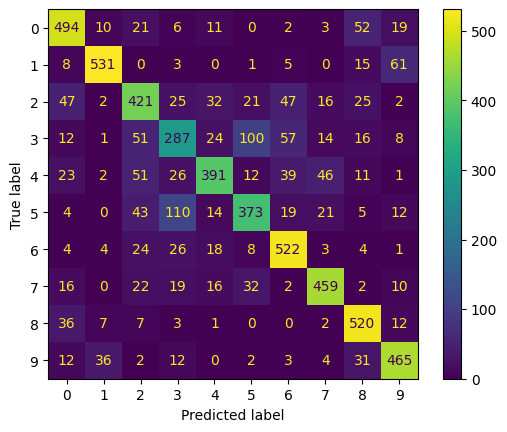

In [39]:
plot_confusion_matrix(labels, predictions)

**_Q9: How does the test loss and accuracy compare to the best training and validation metrics?_**


**_Q10: How do you think we could compute the latency inside the `test_model` function? In other words, what code do we add to `test_model` to measure the time it takes to give the model input and then get the output?_**


# Competition

## Import test.csv and Transform Data

In [40]:
import pandas
test_csv = pandas.read_csv("/kaggle/input/datasets/dustinmcdowell89/test-csv/test.csv")
test_dat = test_csv.to_numpy()
test_dat = test_dat[:,1:]
test_dat = test_dat.reshape((1500, 32, 32, 3))
test_dat.shape

(1500, 32, 32, 3)

In [41]:
comp_dataset = CIFAR10_Dataset(test_dat, np.zeros((1500,)), transform=transform, target_transform=target_transform)

In [42]:
comp_dataloader = torch.utils.data.DataLoader(
    comp_dataset,
    batch_size=1,
    shuffle=False
)

## Run Data Through Model

In [44]:
def run_comp_data(
    test_dataloader: torch.utils.data.DataLoader,
    model_class: torch.nn.Module,
    model_weights_path: Path,
    device: str,
    loss_function
):
    """Load the saved model and evaluate it using the test dataset to determine
    how well it was trained.

    :param test_dataloader: The test dataset DataLoader to get the data from.
    :type test_dataloader: torch.utils.data.DataLoader
    :param model_class: The model to evaluate.
    :type model_class: torch.nn.Module
    :param model_weights_path: The path the the model's weights.
    :type model_weights_path: Path
    :param device: The device to use for evaluation (i.e. inference).
    :type device: str
    :param loss_function: The loss function to use to compute the test loss.
    :return: A tuple containing the total average loss and accuracy as well as
        two list containing the predictions and ground-truth labels.
    :rtype: tuple
    """
    # Initialize the model architecture
    model: torch.nn.Module = model_class()
    # Load the weights
    model.load_state_dict(torch.load(model_weights_path, weights_only=True))
    # Enter the model into evaluation mode (i.e. DO NOT TRAIN)
    model.eval()

    # Send the model to the device to use for inference
    model.to(device)
    # Number of batched iterations
    total_steps = len(test_dataloader)
    # Vars for metrics and results
    running_loss = 0.0
    running_acc = 0.0
    all_predictions = []
    all_labels = []
    all_latencies = []

    # Warm up loop
    warmup_iters = 20        
    input_shape = (1, 3, 32, 32)
    
    # Optional: pre-allocate a tensor to avoid first allocation cost
    _example_input = torch.empty(input_shape, device=device)
    
    with torch.inference_mode():   # or torch.no_grad() if older torch
        for i in range(warmup_iters):
            # if your dataloader provides CPU tensors, .to(device) can be measured;
            # here we use already-on-device dummy tensor to isolate model cost
            out = model(_example_input)
            # make sure all CUDA work is finished before continuing
            torch.cuda.synchronize()
            
    # Testing/Evaluation loop
    for i, (images, labels) in enumerate(test_dataloader):
        # Send data to the inference device
        images = images.to(device)
        labels = labels.to(device)
        batch_size = images.size(0)

        # Perform inference on batched data
        torch.cuda.synchronize()
        begin_time = time.perf_counter()
        outputs = model(images)
        torch.cuda.synchronize()
        end_time = time.perf_counter()
        batch_latency = 1000 * (end_time - begin_time)
        per_sample_latency = batch_latency / batch_size
        all_latencies.extend([per_sample_latency] * batch_size)
        

        # Compute the loss (error) between the output and the ground-truths
        loss = loss_function(outputs, labels)

        # Compute the accuracy
        accuracy = compute_accuracy(outputs, labels)

        # Keep a running loss and accuracy for computing the average
        running_loss += loss.item()
        running_acc += accuracy

        # Concatenate all of the predictions and ground-truths
        all_predictions = all_predictions + torch.argmax(outputs, 1).tolist()
        all_labels = all_labels + labels.tolist()
    # Compute the average loss and accuracy
    avg_accuracy = running_acc / len(test_dataloader)
    avg_latency = sum(all_latencies) / len(test_dataloader)
    return all_predictions, all_latencies, avg_accuracy, avg_latency

In [45]:
%%time
(labels, latencies, accuracy, latency) = run_comp_data(
  comp_dataloader,
  VGGModel,
  './models/vgg/model_state_dict.pt',
  DEVICE,
  loss 
 )
print(f"Num labels: {len(labels)}")
print(f"Num latencies: {len(latencies)}")
print(latencies[0:10])

Num labels: 1500
Num latencies: 1500
[0.8097980000911775, 0.7872879998558346, 0.7516620000842522, 0.8369570000468229, 0.797811999973419, 0.763530000085666, 0.8421410000210017, 0.7503050001105294, 0.7613400000536785, 0.8066499999586085]
CPU times: user 2.03 s, sys: 6.69 ms, total: 2.04 s
Wall time: 2.06 s


In [46]:
# write results to csv file
df = pandas.DataFrame({
    "id": [i for i in range(len(labels))],
    "label": labels,
    "latency": latencies
})
df.to_csv("/kaggle/working/results.csv", index=False)
import os
os.listdir("/kaggle/working")

['dataset', 'models', 'results.csv', '.virtual_documents']